In [3]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

from df2gspread import df2gspread as d2g
from gspread_dataframe import get_as_dataframe, set_with_dataframe

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
from decouple import config

In [5]:
import geopandas as gpd

## Read google sheets

Define the scope

In [6]:
# define the scope and credentials
SCOPE = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
CREDENTIALS = json.loads(config('CRED_GCP'))


Credentials

In [11]:
# add credentials to the account
#credentials = ServiceAccountCredentials.from_json_keyfile_name(API_FILE, SCOPE)
credentials = ServiceAccountCredentials.from_json_keyfile_dict(CREDENTIALS, SCOPE)

# authorize the clientsheet
client = gspread.authorize(credentials)

# get the instance of the Spreadsheet
sheet = client.open('Copy of N2N - Database')

# get the first sheet of the Spreadsheet
sheet_instance = sheet.get_worksheet(0)

In [10]:
# get the total number of columns
print(sheet_instance.col_count)
print(sheet_instance.row_count)

16
4979


Database

In [11]:
data = sheet_instance.get_all_values()
df = pd.DataFrame(data[1:], columns=data[0])

In [12]:
df.head()

,#,Date,City,Season,Industry / Event,Format,Attendance,Email,First Name,Last Name,Country of Origin,Area of Expertise,Employment Status,Employer,Dream Job,Linkedin
0,1,"January 14, 2021",Toronto,1,HR,Online,Checked In,fabysantanar@gmail.com,Fabiana,Santana,Venezuela,"Employee Experience, Business Partner",Employed,Spin Master,,
1,1,"January 14, 2021",Toronto,1,HR,Online,Checked In,davhd21@gmail.com,David,Herrera,Mexico,Talent,Employed,Korn Ferry,,
2,1,"January 14, 2021",Toronto,1,HR,Online,Checked In,karla.cadario@wilsonhcg.com,Karla,Cadario Moreno,Bolivia,Reclutamiento y Seleccion,Employed,WilsonHCG,,
3,1,"January 14, 2021",Toronto,1,HR,Online,Checked In,eri_mabu@hotmail.com,Erika,Martínez,Colombia,Recruiting,Employed,Accenture,,
4,1,"January 14, 2021",Toronto,1,HR,Online,Checked In,padronalfredo@outlook.com,Alfredo,Padron,Venezuela,Tech,Employed,Scotiabank,,


### Header

In [13]:
total_registered = df['Attendance'].count()
total_registered

4978

In [14]:
total_attendance = df[df['Attendance'] == 'Checked In']['Attendance'].count()
total_attendance

1816

In [15]:
toronto_season = df[df['City']=='Toronto']['Season'].max()
toronto_season

'9'

In [16]:
montreal_season = df[df['City']=='Montreal']['Season'].max()
montreal_season

'1'

In [17]:
df[df['City']=='Montreal'][['Date','Season']]

,Date,Season
3402,"September 20, 2023",1
3403,"September 20, 2023",1
3404,"September 20, 2023",1
3405,"September 20, 2023",1
3406,"September 20, 2023",1
...,...,...
4742,"November 9, 2023",1
4743,"November 9, 2023",1
4744,"November 9, 2023",1
4745,"November 9, 2023",1


In [18]:
df.loc[df['City']=='Montreal',['Date','Season']]

,Date,Season
3402,"September 20, 2023",1
3403,"September 20, 2023",1
3404,"September 20, 2023",1
3405,"September 20, 2023",1
3406,"September 20, 2023",1
...,...,...
4742,"November 9, 2023",1
4743,"November 9, 2023",1
4744,"November 9, 2023",1
4745,"November 9, 2023",1


### Employment Status Attendees

In [19]:
filtered_df = df[(df['Employment Status']!='') &
                 (df['Employment Status']!='Maternity Leave / Full-time Mom') &
                 (df['Employment Status']!='Entrepreneur')
                 ]
employment_status = filtered_df['Employment Status'].value_counts()
employment_status


Employment Status
Unemployed and looking for opportunities        1741
Employed and looking for opportunities          1371
Employed                                         829
Employed and looking for opportunitiesnone        36
Unemployed and looking for opportunitiesnone      32
Employednone                                      24
Nonenone                                          12
Name: count, dtype: int64

In [20]:
fig = px.bar(x=employment_status.index, y=employment_status.values, labels={'x': 'Employment Status', 'y': 'Count'})
fig.show()

### Attendee's Countries

In [21]:
filtered_df = df[df['Country of Origin']!='']
top_6_countries = filtered_df['Country of Origin'].value_counts().nlargest(6)
top_6_countries

Country of Origin
Colombia              1706
Mexico                 485
Venezuela              355
Peru                   303
Dominican Republic     198
Ecuador                160
Name: count, dtype: int64

In [22]:
figure = px.bar(x=top_6_countries.values, y=top_6_countries.index, labels={'x': '', 'y': 'Employment Status'})
figure.show()

In [23]:
top_6_countries_sorted = top_6_countries.sort_values(ascending=True)

figure = px.bar(x=top_6_countries_sorted.values, y=top_6_countries_sorted.index, labels={'x': '', 'y': 'Employment Status'})
figure.show()

In [24]:
df['Country of Origin']

0          Venezuela
1             Mexico
2            Bolivia
3           Colombia
4          Venezuela
            ...     
4973    Colombianone
4974        Perunone
4975       Chilenone
4976        Nonenone
4977        Nonenone
Name: Country of Origin, Length: 4978, dtype: object

In [25]:
country_counts = df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['name', 'count']

fig5 = px.choropleth(
    country_counts,
    locations='name',
    locationmode='country names',
    color='count',
    hover_name='name',
    color_continuous_scale='Viridis_r',
    #title='Estimate Smoking Prevalence by Country over the years',
)
fig5.update_geos(
    showcoastlines=True,
    coastlinecolor='RebeccaPurple',
    showland=True,
    landcolor='LightGrey',
    showocean=True,
    oceancolor='LightBlue',
    projection_type='orthographic',
)
fig5.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title='Attendants by country'),
)
fig5.show()

C:\Users\david\AppData\Local\Temp\ipykernel_3488\3625389501.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



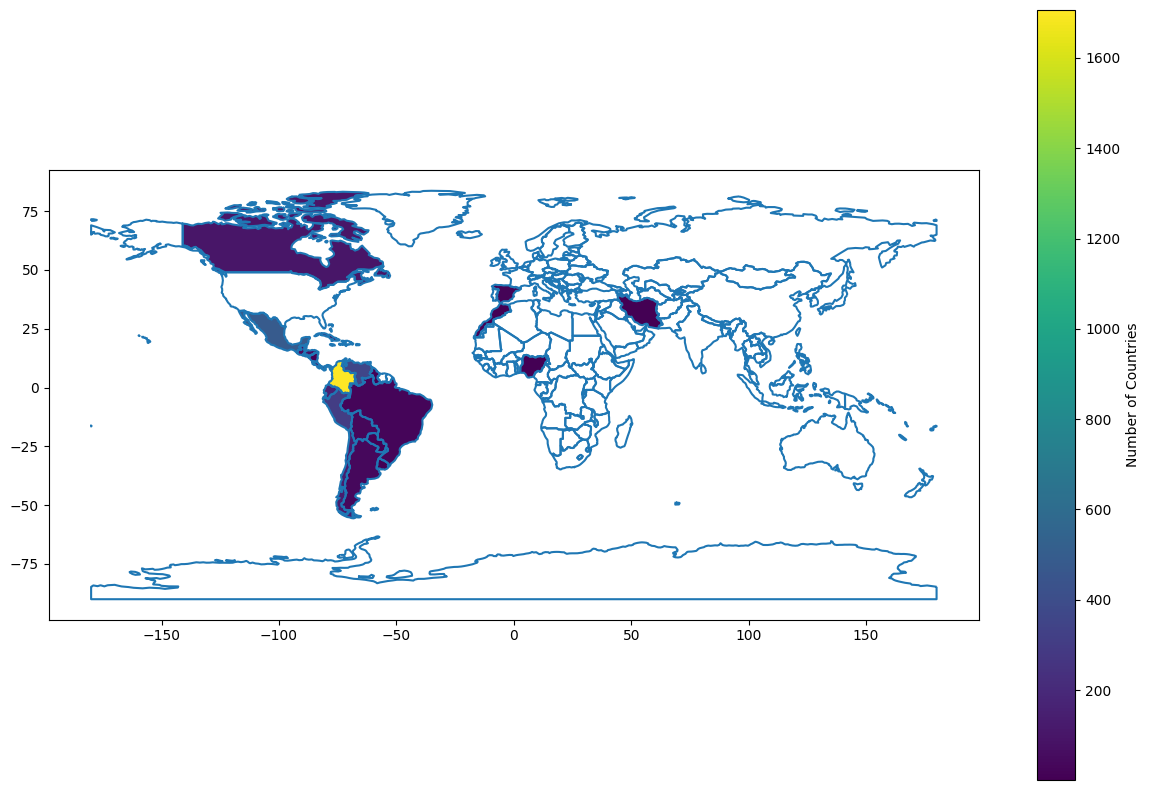

In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Count the number of occurrences of each country in the DataFrame
country_counts = df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['name', 'count']

# Merge the world shapefile with the country counts DataFrame
world = world.merge(country_counts, how='left', left_on='name', right_on='name')

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='count', ax=ax, legend=True, legend_kwds={'label': "Number of Countries"})
plt.show()

### Pie charts

In [27]:
df.columns

Index(['#', 'Date', 'City', 'Season', 'Industry / Event', 'Format',
       'Attendance', 'Email', 'First Name', 'Last Name', 'Country of Origin',
       'Area of Expertise', 'Employment Status', 'Employer', 'Dream Job',
       'Linkedin'],
      dtype='object')

In [28]:
figure = px.pie(df, names='Format', title='Attendees by Event mode')
figure.show()

In [29]:
figure = px.pie(df, names='City', title='Attendees by City')
figure.show()

### Notworking to Networking Over Time

In [30]:
df.columns

Index(['#', 'Date', 'City', 'Season', 'Industry / Event', 'Format',
       'Attendance', 'Email', 'First Name', 'Last Name', 'Country of Origin',
       'Area of Expertise', 'Employment Status', 'Employer', 'Dream Job',
       'Linkedin'],
      dtype='object')

In [31]:
df['Date'] = pd.to_datetime(df['Date'])

In [32]:
attendance_grouped = df.groupby(['Date', 'Attendance']).size().reset_index(name='count')
attendance_grouped.loc[attendance_grouped['Attendance'] == 'Attending', 'Attendance'] = 'Not Attending'


In [33]:
attendance_grouped['cumulative_count'] = attendance_grouped.groupby('Attendance')['count'].cumsum()

In [34]:
attendance_grouped['total_count'] = attendance_grouped['count'].cumsum()


In [35]:
attendance_grouped

,Date,Attendance,count,cumulative_count,total_count
0,2021-01-14,Checked In,10,10,10
1,2021-01-21,Checked In,17,27,27
2,2021-01-30,Checked In,22,49,49
3,2021-02-04,Checked In,22,71,71
4,2021-02-09,Checked In,25,96,96
...,...,...,...,...,...
253,2023-11-23,Not Attending,3,3145,4958
254,2023-11-23,Not Attending,2,3147,4960
255,2023-11-27,Not Attending,13,3160,4973
256,2023-11-27,Checked In,3,1816,4976


In [36]:
# Creating a line plot using Plotly Express
fig = px.line(attendance_grouped, x='Date', y='count', color='Attendance', markers=True, title='Attendance Count Over Time')
fig.show()


In [37]:
fig = px.line(attendance_grouped, x='Date', y= 'total_count', markers=True, title='Attendance Count Over Time')
fig.show()

In [38]:
fig = px.line(attendance_grouped, x='Date', y=['count', 'total_count'], color='Attendance', markers=True, title='Attendance Count Over Time')
fig.show()

### Attendees by Industry

In [39]:
df[['#', 'Industry / Event', 'Format', 'Attendance']]

,#,Industry / Event,Format,Attendance
0,1,HR,Online,Checked In
1,1,HR,Online,Checked In
2,1,HR,Online,Checked In
3,1,HR,Online,Checked In
4,1,HR,Online,Checked In
...,...,...,...,...
4973,176,Legal,Online,Attending
4974,176,Legal,Online,Checked In
4975,176,Legal,Online,Attending
4976,176,Legal,Online,Not Attending


In [40]:
df_attendees = df[['#', 'Industry / Event', 'Format', 'Attendance']].value_counts().sort_index().reset_index(name='Count')
df_attendees

,#,Industry / Event,Format,Attendance,Count
0,1,HR,Online,Checked In,10
1,10,Hospitality & Tourism,Online,Checked In,20
2,100,Social Work & Mental Health,In Person,Attending,34
3,101,Retail,Online,Attending,11
4,101,Retail,Online,Checked In,3
...,...,...,...,...,...
270,97,Engineering,Online,Attending,27
271,97,Engineering,Online,Checked In,6
272,98,Engineering,In Person,Attending,35
273,99,Social Work & Mental Health,Online,Attending,29


In [41]:
attendance_grouped = df.groupby(['Date', 'Attendance']).size().reset_index(name='count')
attendance_grouped.loc[attendance_grouped['Attendance'] == 'Attending', 'Attendance'] = 'Not Attending'

In [42]:
df_attendees=df_attendees.groupby(['Industry / Event', 'Format'])['Count'].sum().reset_index()

In [43]:
df_average_attendees = df_attendees.groupby(['Industry / Event', 'Format']).agg({'Count': ['sum', 'count']}).reset_index()
df_average_attendees.columns = ['Industry / Event', 'Format', 'Sum_Count', 'Count']

In [44]:
df_average_attendees['Average']= df_average_attendees['Sum_Count']/df_average_attendees['Count']

In [45]:
df_average_attendees

,Industry / Event,Format,Sum_Count,Count,Average
0,Accounting,In Person,10,1,10.0
1,Accounting,Online,22,1,22.0
2,"Advertising, Media & Film",In Person,94,1,94.0
3,"Advertising, Media & Film",Online,88,1,88.0
4,Architecture,In Person,38,1,38.0
...,...,...,...,...,...
65,Workshop: How to Write Business English (for N...,Online,116,1,116.0
66,Workshop: Insider Secrets to Landing Ideal Job...,Online,184,1,184.0
67,Workshop: LinkedIn Workshop to Advance Your Ca...,Online,541,1,541.0
68,Workshop: Secrets to Crafting The Perfect Job ...,Online,36,1,36.0


In [46]:
df.columns

Index(['#', 'Date', 'City', 'Season', 'Industry / Event', 'Format',
       'Attendance', 'Email', 'First Name', 'Last Name', 'Country of Origin',
       'Area of Expertise', 'Employment Status', 'Employer', 'Dream Job',
       'Linkedin'],
      dtype='object')

In [47]:
filtered_df = df[(df['Industry / Event']!='Workshop: LinkedIn Workshop to Advance Your Career') &
                 (df['Industry / Event']!='Workshop: Insider Secrets to Landing Ideal Jobs (for Newcomers)') &
                 (df['Industry / Event']!='Workshop: Secrets to Crafting The Perfect Job Application by Izzy Piyale-Sheard') &
                 (df['Industry / Event']!='Workshop: Top 22 Tips to Get a Job in 2022') &
                 (df['Industry / Event']!='Workshop: How to Write Business English (for Newcomers)') ]
#top_9_industry = filtered_df[['Industry / Event','Format']].value_counts().nlargest(20).to_frame().reset_index()
top_9_industry = filtered_df[['Industry / Event','Format']].value_counts().to_frame().reset_index()

In [48]:
filtered_df['Industry / Event'].unique()

array(['HR', 'Banking, Finance & Insurance', 'Operations & Logistics',
       'Marketing', 'IT', 'Architecture', 'Engineering', 'Legal', 'Sales',
       'Hospitality & Tourism', 'Design', 'Real Estate',
       'Fitness, Nutrition & Wellness', 'Project Management',
       'Education & Learning', 'Art & Entertainment', 'Consulting',
       'Medicine & Pharmacy', 'Entrepreneurship',
       'Crypto, NFT & Blockchain', 'Mental Health',
       'Advertising, Media & Film', 'Fashion', 'Retail',
       'Construction & Trades', 'Moms', 'Accounting', 'S7 Party',
       'Social Work & Mental Health', 'S8 Party', 'Volunteer Training',
       'Executive & Adm Assistants', 'Data Analysis', 'Education',
       'Design & Graphic Design'], dtype=object)

In [49]:
top_9_industry

,Industry / Event,Format,count
0,IT,Online,229
1,Marketing,Online,218
2,Engineering,Online,209
3,Marketing,In Person,187
4,IT,In Person,182
...,...,...,...
60,Mental Health,In Person,8
61,Legal,In Person,8
62,Medicine & Pharmacy,Online,7
63,"Fitness, Nutrition & Wellness",Online,7


In [50]:
fig = px.bar(top_9_industry,x='Industry / Event', y='count',color='Format', barmode='group',labels={'x': 'Industry / Event', 'y': 'Format'})
fig.show()

In [51]:
fig = px.histogram(filtered_df,x='Industry / Event',color='Format',  barmode='group')
fig.show()

### Average Attendees by Industry

# 1 

# 2

# 3

# 4

# 5

# 6